Loading Lorenz-63 data...
Lorenz-63 data shape: (1200, 3)
x sensitivities shape: (400, 3)
y sensitivities shape: (400, 3)
z sensitivities shape: (400, 3)
Full design matrix shape: (1200, 3)

Running D-optimal design algorithm...


D_optimal:  50%|████▉     | 99/200 [00:00<00:00, 269.23it/s]


Convergence achieved after 100 iterations.


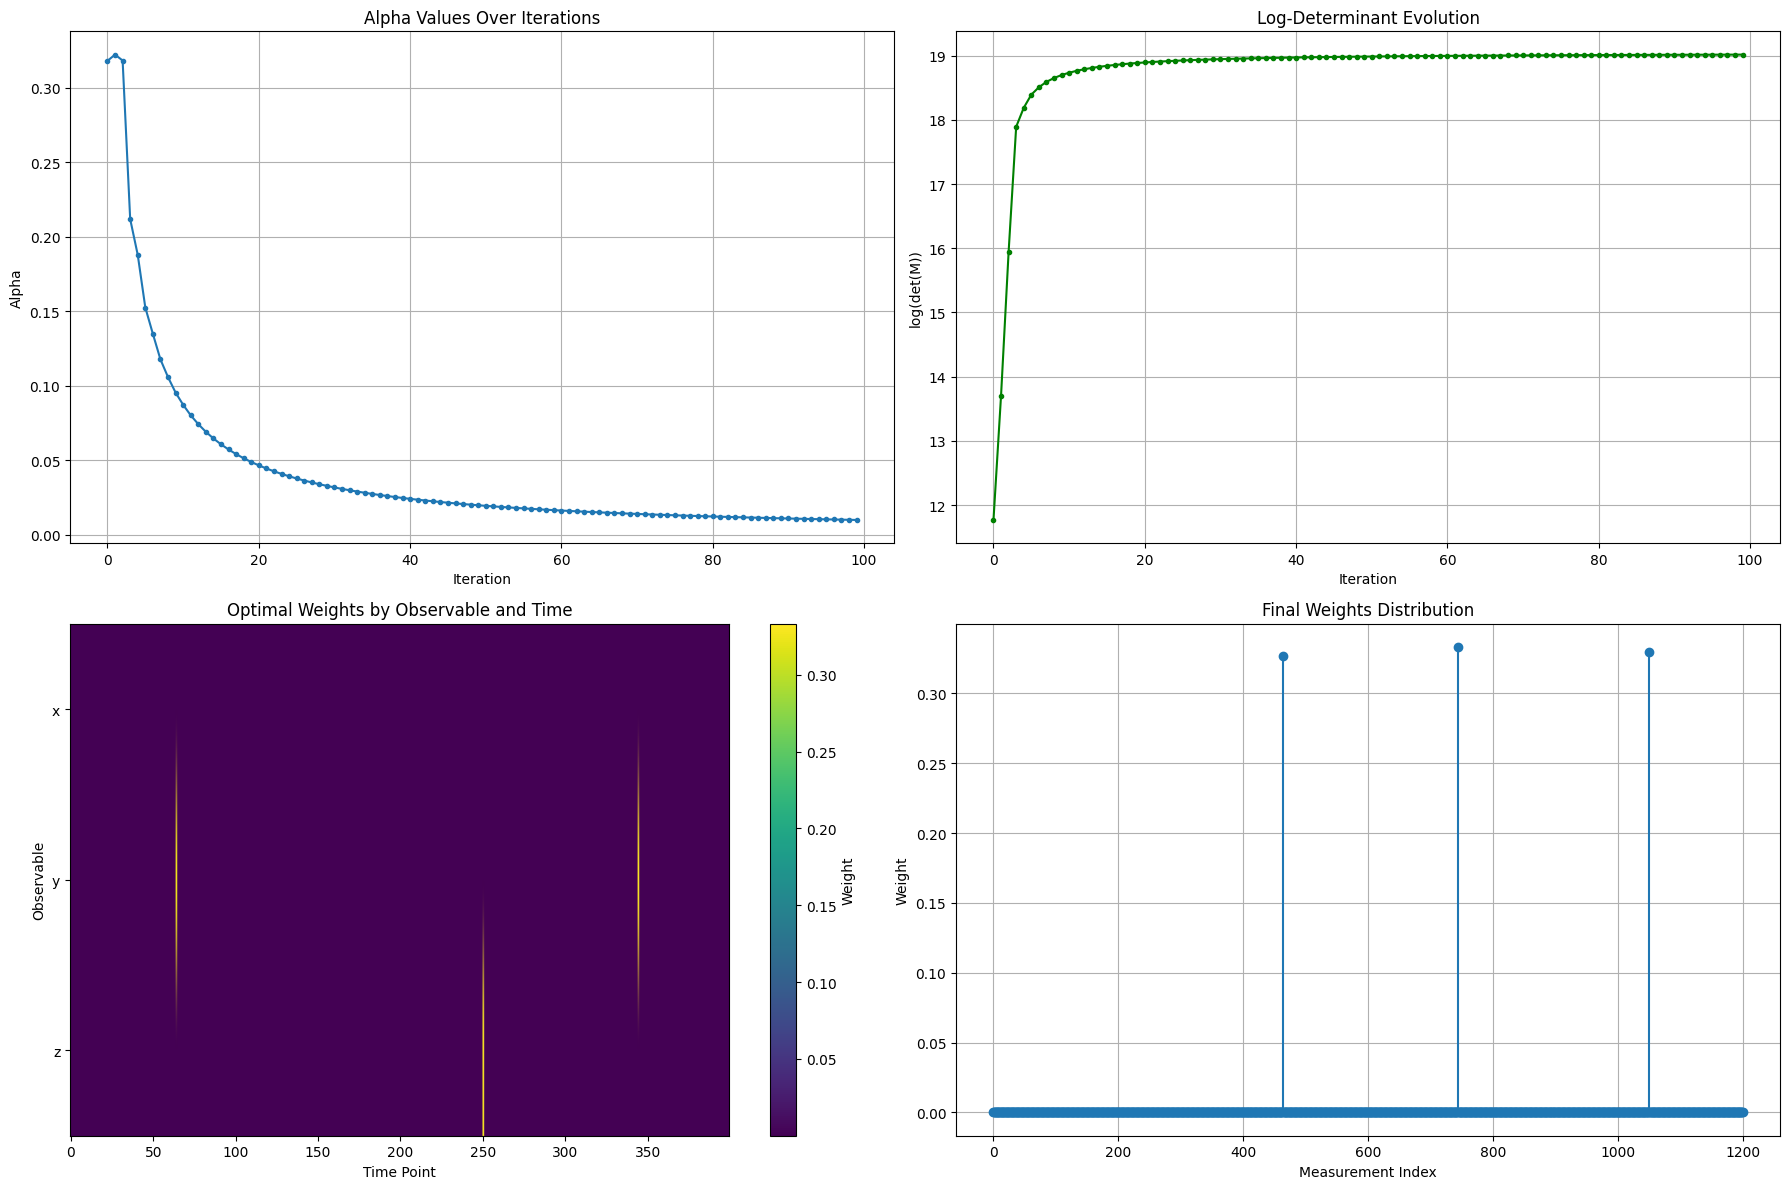


Standout weights
Index: 464, Weight: 0.3265, Observable: y, Time: 64
Index: 744, Weight: 0.3331, Observable: y, Time: 344
Index: 1050, Weight: 0.3295, Observable: z, Time: 250

Total weight by observable:
x: 0.0036 (0.4%)
y: 0.6632 (66.3%)
z: 0.3332 (33.3%)


In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("Loading Lorenz-63 data...")
data = scipy.io.loadmat('L63data.mat')
X_l63 = data['L63data']
print("Lorenz-63 data shape:", X_l63.shape)

x_sensitivities = X_l63[:400, :]
y_sensitivities = X_l63[400:800, :]
z_sensitivities = X_l63[800:, :]

print(f"x sensitivities shape: {x_sensitivities.shape}")
print(f"y sensitivities shape: {y_sensitivities.shape}")
print(f"z sensitivities shape: {z_sensitivities.shape}")

np.random.seed(42)
num_time_points = 400
num_observables = 3
num_parameters = 3
num_candidates = num_time_points * num_observables

initial_weights = np.random.rand(num_candidates)
initial_weights /= np.sum(initial_weights)

design_matrix = np.zeros((num_candidates, num_parameters))
design_matrix[:400, :] = x_sensitivities
design_matrix[400:800, :] = y_sensitivities
design_matrix[800:, :] = z_sensitivities
print(f"Full design matrix shape: {design_matrix.shape}")

def D_optimal(X, initial_weights, num_iterations=100, tol=0.01):
    num_obs = X.shape[0]
    weights = np.diag(initial_weights / np.sum(initial_weights))
    alpha_history = []
    log_det_history = []
    
    for i in tqdm(range(num_iterations), desc='D_optimal'):
        M = X.T @ weights @ X
        det_M = np.linalg.det(M)
        if det_M <= 0:
            print(f"Warning: Matrix M is singular at iteration {i}")
            M += np.eye(X.shape[1]) * 1e-10
            det_M = np.linalg.det(M)

        log_det_history.append(np.log(det_M))
        M_inv = np.linalg.inv(M)
        d_values = np.array([X[j].T @ M_inv @ X[j] for j in range(num_obs)])
        
        max_index = np.argmax(d_values)
        d_xi = d_values[max_index]
        alpha_i = (d_xi - X.shape[1]) / (X.shape[1] * (np.max(d_values) - 1))
        alpha_history.append(alpha_i)

        if alpha_i < 0 or alpha_i > 1:
            print("Alpha out of bounds:", alpha_i, "at iteration", i)
            break

        new_weights = (1 - alpha_i) * weights
        new_weights[max_index, max_index] += 1 - np.sum(new_weights)
        weights = new_weights

        if np.abs(alpha_i) < tol:
            print("Convergence achieved after", i + 1, "iterations.")
            break
            
    return weights, alpha_history, log_det_history

print("\nRunning D-optimal design algorithm...")
weights_l63, alpha_hist_l63, log_det_hist_l63 = D_optimal(design_matrix, initial_weights, num_iterations=200, tol=0.01)
final_weights = np.diag(weights_l63)

weight_matrix = np.zeros((3, 400))
weight_matrix[0, :] = final_weights[:400]
weight_matrix[1, :] = final_weights[400:800]
weight_matrix[2, :] = final_weights[800:1200]

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].plot(alpha_hist_l63, marker='o', markersize=3)
axs[0, 0].set_title('Alpha Values Over Iterations')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Alpha')
axs[0, 0].grid(True)

axs[0, 1].plot(log_det_hist_l63, marker='o', markersize=3, color='green')
axs[0, 1].set_title('Log-Determinant Evolution')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('log(det(M))')
axs[0, 1].grid(True)

im = axs[1, 0].imshow(weight_matrix, aspect='auto', cmap='viridis')
axs[1, 0].set_title('Optimal Weights by Observable and Time')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Observable')
axs[1, 0].set_yticks([0, 1, 2])
axs[1, 0].set_yticklabels(['x', 'y', 'z'])
plt.colorbar(im, ax=axs[1, 0], label='Weight')

axs[1, 1].stem(final_weights, basefmt=" ")
axs[1, 1].set_title('Final Weights Distribution')
axs[1, 1].set_xlabel('Measurement Index')
axs[1, 1].set_ylabel('Weight')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

average_weight = np.mean(final_weights)
std_weight = np.std(final_weights)
standout_threshold = average_weight + 2 * std_weight
standout_indices = np.where(final_weights > standout_threshold)[0]

print("\nStandout weights")
for idx in standout_indices:
    if idx < 400:
        observable = 'x'; time = idx
    elif idx < 800:
        observable = 'y'; time = idx - 400
    else:
        observable = 'z'; time = idx - 800
    print(f"Index: {idx}, Weight: {final_weights[idx]:.4f}, Observable: {observable}, Time: {time}")

x_total_weight = np.sum(final_weights[:400])
y_total_weight = np.sum(final_weights[400:800]) 
z_total_weight = np.sum(final_weights[800:])

print("\nTotal weight by observable:")
print(f"x: {x_total_weight:.4f} ({x_total_weight*100:.1f}%)")
print(f"y: {y_total_weight:.4f} ({y_total_weight*100:.1f}%)")
print(f"z: {z_total_weight:.4f} ({z_total_weight*100:.1f}%)")